In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.base import clone


class ExampleModelRank:
    def __init__(self):
        self._model = Ridge(fit_intercept=False, alpha=1e7)
        self._model = Pipeline([
            ('ss', StandardScaler()),
            ('model', self._model)
        ])
        # self._model = BaggingRegressor(self._model, random_state=1)
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        # df['ret_train'] = df['ret']
        df['ret_train'] = df['cl'].shift(-24 * 3) / df['cl'].shift(-2) - 1
        
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        # self._models = {}
        # for market, df_symbol in df.groupby('symbol'):
        #     self._models[market] = clone(self._model)
        #     self._models[market].fit(df_symbol[features], np.sign(df_symbol['ret_beta']), sample_weight=np.abs(df_symbol['ret_beta']))
        
        # self._model.fit(df[features], df['ret_train'])
        self._model.fit(df[features], np.sign(df['ret_train']), model__sample_weight=np.abs(df['ret_train']))
        # self._model.fit(df[features], np.sign(df['ret_train']), sample_weight=np.abs(df['ret_train']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        y_pred = self._model.predict(df[features])
        df['position'] = np.sign(y_pred)
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        def MACD(cl, t1=12, t2=26, t3=9):
            m1 = cl.rolling(t1, 1).mean()
            m2 = cl.rolling(t2, 1).mean()
            macd = (m1 / m2 - 1).fillna(0)
            signal = macd.rolling(t3, 1).mean()
            return macd, signal
    
        df['feature_momentum'] = (df['cl'] / df['cl'].shift(24 * 30) - 1).fillna(0)
        df['cl_diff'] = (df['cl'] - df['cl'].shift(1)).fillna(0)
        df['volume_diff'] = (df['volume'] - df['volume'].shift(1)).fillna(0)
        rsi_time = 24 * 3
        df['feature_rsi'] = (np.maximum(0, df['cl_diff']).rolling(rsi_time, 1).sum() / df['cl_diff'].abs().rolling(rsi_time, 1).sum() - 0.5).fillna(0)
        # df['feature_volume_rsi'] = (np.maximum(0, df['volume_diff']).rolling(rsi_time).sum() / df['volume_diff'].abs().rolling(rsi_time).sum() - 0.5).fillna(0)

        df['feature_macd'], df['feature_macd_signal'] = MACD(df['cl'], 12 * 24, 26 * 24, 9 * 24) 

        df['feature_kairi'] = (df['cl'] / df['cl'].rolling(24 * 14, 1).mean() - 1).fillna(0)
    #     df['vola'] = df['cl'].rolling(24 * 14).std()
    #     df['feature_vola'] = df['vola'].diff(24 * 14)

    #     fdiff = FractionalDifferentiation()
    #     df['feature_x_frac1'] = fdiff.frac_diff(np.log(df[['cl']]).diff(1), 0.1, thresh=0.1).values.flatten()
    #     df['feature_x_frac2'] = fdiff.frac_diff(np.log(df[['cl']]).diff(1), -0.1, thresh=0.1).values.flatten()

        return df

fit df.shape (21926, 15)
fit df.shape (21901, 15)
fit df.shape (21901, 15)
fit df.shape (21901, 15)
fit df.shape (21927, 15)
return without cost statistics
mean 0.0021811052233882346
std 0.03815980592410495
sharpe 0.05715713616904075
max drawdown 0.6406742860316451
return with cost statistics
mean 0.0019151268913879503
std 0.0381723153554305
sharpe 0.0501705718805841
max drawdown 0.6406742860316451


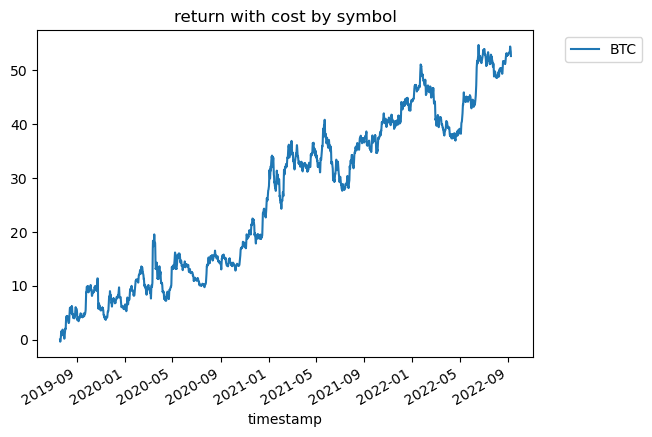

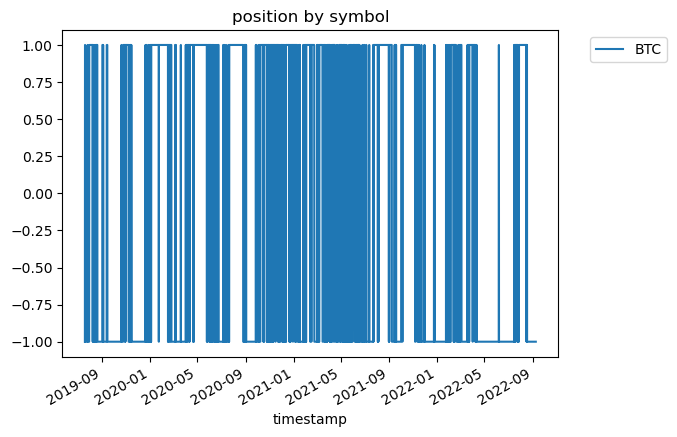

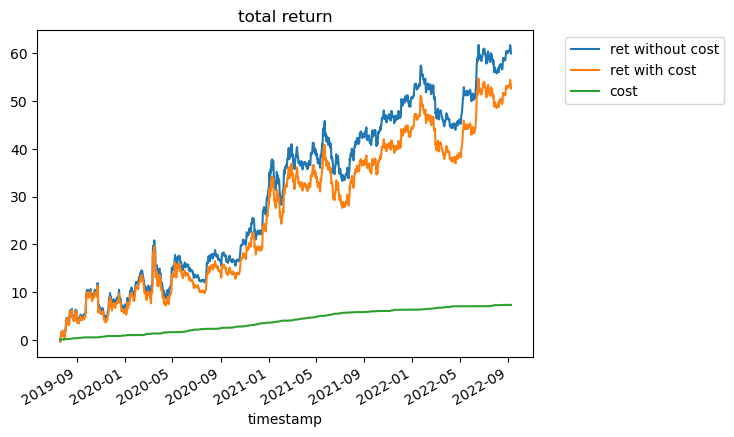

fit df.shape (27458, 15)


In [3]:
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df.loc[df.index.get_level_values('symbol').isin(['BTC'])]
# df = df.loc[df.index.get_level_values('symbol').isin(['ETH'])]
# df = df.loc[df.index.get_level_values('symbol').isin(['BTC', 'ETH'])]
# df = df.loc[df.index.get_level_values('symbol').isin(['LINK'])]

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220917_mom.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-07-11 16:00:00+00:00  BTC      -1.0
2022-07-11 17:00:00+00:00  BTC       1.0
2022-07-11 18:00:00+00:00  BTC       1.0
2022-07-11 19:00:00+00:00  BTC       1.0
2022-07-11 20:00:00+00:00  BTC      -1.0
                                    ... 
2022-09-09 12:00:00+00:00  BTC      -1.0
2022-09-09 13:00:00+00:00  BTC      -1.0
2022-09-09 14:00:00+00:00  BTC      -1.0
2022-09-09 15:00:00+00:00  BTC      -1.0
2022-09-09 16:00:00+00:00  BTC      -1.0
Name: position, Length: 1441, dtype: float64
['BTC']
test shift predict


,,position1,position2,position3
timestamp,symbol,,,
2022-07-11 17:00:00+00:00,BTC,1.0,1.0,-1.0
2022-07-11 18:00:00+00:00,BTC,1.0,1.0,-1.0
2022-07-11 19:00:00+00:00,BTC,1.0,1.0,-1.0
2022-07-11 20:00:00+00:00,BTC,-1.0,-1.0,-1.0
2022-07-11 21:00:00+00:00,BTC,-1.0,-1.0,-1.0
...,...,...,...,...
2022-09-09 11:00:00+00:00,BTC,-1.0,-1.0,-1.0
2022-09-09 12:00:00+00:00,BTC,-1.0,-1.0,-1.0
2022-09-09 13:00:00+00:00,BTC,-1.0,-1.0,-1.0


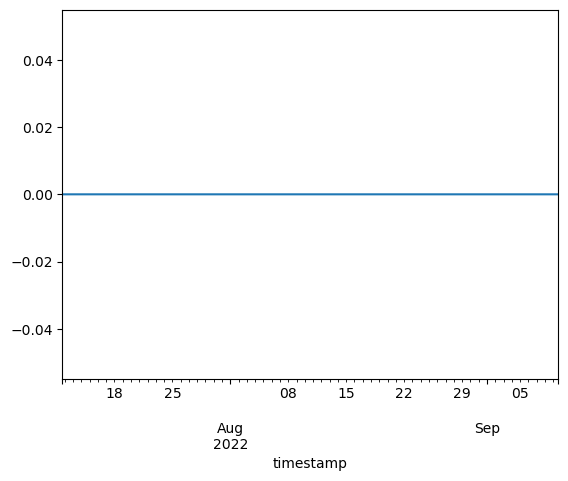

BTC (1439, 4)


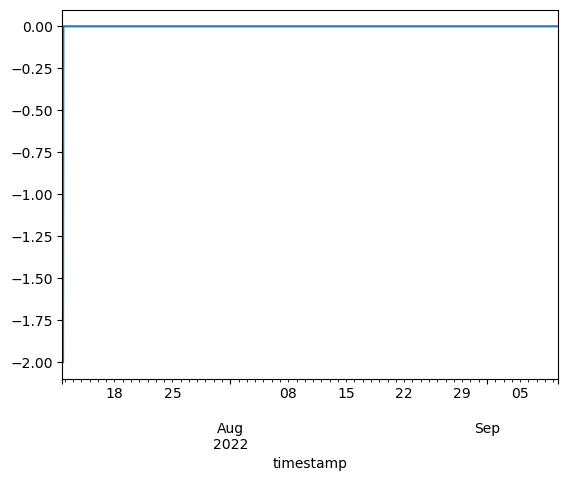

In [5]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220917_mom.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df.loc[df.index.get_level_values('symbol').isin(['BTC'])]

df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()